In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import condpf
from condpf.condpf_class import CondPF
tod = torch.distributions

$dX_{t} = \mu(X_{t})dt + \sigma(X_{t})dW_{t}$

$Y_{t}|X_{t} \sim_{i.i.d} g(y_{t},x_{t})$

For illustration, we specidy a specific Ornstein–Uhlenbeck process with Gaussian noise Partially Observed Diffusion model with discrete observations (PODPDO).

Class object for PODPDO, suitable for high-dimensional implementation

In [2]:
class PODPDO(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.theta = torch.nn.Parameter(torch.tensor([0.0,1.0,0.1]))
    
    # Drift function: x shape [N, dx]
    def mu(self, x):
        return -(self.theta[0]*x)  

    # Diffusion function: x shape [N, dx]
    def sigma(self, x):
        return self.theta[1]*torch.eye(x.shape[-1]).repeat(x.shape[0],1,1)
    
    # log PDF of Y_t|X_t : x shape [N, dx] y shape [dy] (dy=dx)
    def likelihood_logscale(self, x, y):
        dist_yx = tod.MultivariateNormal(loc=x, covariance_matrix=torch.eye(y.shape[-1])*self.theta[2]**2)
        gn = dist_yx.log_prob(y)
        return gn

#### Convergence Effect: CondPF is a Markov Kernel invariant wrt the filtering distribution

1. Observation lies on a (2-d) straight line

In [507]:
l=4
T=10
N=100
dx=2
dy=2

# dim_w = dim_x
initial_val = torch.tensor([1.0,1.0])
param = l, T, N, dx, dy, initial_val

pod = PODPDO()
con = CondPF(pod, param)

In [508]:
y_concen = np.zeros((T+1, dy))
y_concen = y_concen + 1
y_concentrate = torch.tensor(y_concen).float()

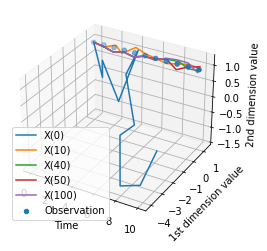

In [518]:
chain = con.chain_gen(100, y_concentrate)
chain_numpy = chain.detach().numpy()

t = np.arange(T+1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Time')
ax.set_ylabel('1st dimension value')
ax.set_zlabel('2nd dimension value')
ax.plot(t,chain_numpy[0,:,0],chain_numpy[0,:,1],label="X(0)")
ax.plot(t,chain_numpy[10,:,0],chain_numpy[10,:,1],label="X(10)")
ax.plot(t,chain_numpy[40,:,0],chain_numpy[40,:,1],label="X(40)")
ax.plot(t,chain_numpy[50,:,0],chain_numpy[50,:,1],label="X(50)")
ax.plot(t,chain_numpy[-1,:,0],chain_numpy[-1,:,1],label="X(100)")
ax.scatter(t,y_concen[:,0],y_concen[:,1],label='Observation')
plt.legend()
plt.show()

2. Observation lies on a 2-d curve

In [520]:
y_concen = np.ones((T+1, dy))
for t in range(1,T+1):
    y_concen[t] = 1.3 * np.array([np.sin(t), np.cos(t)]) 
y_concentrate = torch.tensor(y_concen).float()

In [529]:
chain = con.chain_gen(100, y_concentrate)
chain_numpy = chain.detach().numpy()

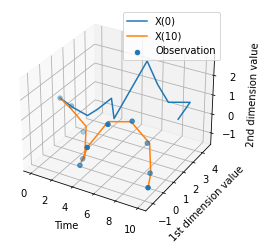

In [530]:
t = np.arange(T+1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Time')
ax.set_ylabel('1st dimension value')
ax.set_zlabel('2nd dimension value')
ax.plot(t,chain_numpy[0,:,0],chain_numpy[0,:,1],label="X(0)")
ax.plot(t,chain_numpy[10,:,0],chain_numpy[10,:,1],label="X(10)")
ax.scatter(t,y_concen[:,0],y_concen[:,1],label='Observation')
plt.legend()
plt.show()

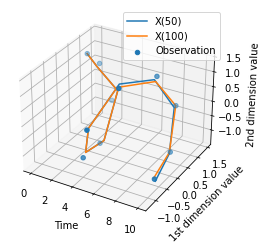

In [534]:
t = np.arange(T+1)

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('Time')
ax.set_ylabel('1st dimension value')
ax.set_zlabel('2nd dimension value')
ax.plot(t,chain_numpy[50,:,0],chain_numpy[50,:,1],label="X(50)")
ax.plot(t,chain_numpy[-1,:,0],chain_numpy[-1,:,1],label="X(100)")
ax.scatter(t,y_concen[:,0],y_concen[:,1],label='Observation')
plt.legend()
plt.show()